In [ ]:
!pip install -q datasets transformers evaluate

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset

ds = load_dataset("Arham-Imran/cityscape_11_classes")

In [ ]:
#ds
#ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
train_ds = train_ds[900:1200]
test_ds = ds["val"]
test_ds = test_ds[200:250]
#test_ds = test_ds[:200]
#train_ds
#test_ds
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2975
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
})

In [ ]:
from google.colab import files
uploaded = files.upload()
with open('Classes.csv', 'r') as fid:
      data = [l.split(',') for i,l in enumerate(fid) if i !=0]
id2label = {x[0]:x[1] for x in data}
id2label

{'0': 'road \n',
 '1': 'sidewalk\n',
 '2': 'building\n',
 '3': 'signboard\n',
 '4': 'vegetation\n',
 '5': 'terrain\n',
 '6': 'sky\n',
 '7': 'person\n',
 '8': 'car\n',
 '9': 'htv\n',
 '10': 'cycle\n'}

In [ ]:
train_ds

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB siz

In [ ]:
import time
img = train_ds['label'][20]
import numpy
from numpy import asarray
from PIL import Image
#data = train_ds[0]["image"]
#data = train_ds[0]["semantic_segmentation"]
data = asarray(img)
print(numpy.max(data))
#train_ds[0]["semantic_segmentation"]

9


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
!pip install -U segmentation-models-pytorch albumentations --user

In [ ]:
print(id2label)
Cat = ['road','sidewalk','building','signboard','vegetation','terrain','sky','person','car','htv','cycle']
print(Cat)
print(len(Cat))

{'0': 'road \n', '1': 'sidewalk\n', '2': 'building\n', '3': 'signboard\n', '4': 'vegetation\n', '5': 'terrain\n', '6': 'sky\n', '7': 'person\n', '8': 'car\n', '9': 'htv\n', '10': 'cycle\n'}
['road', 'sidewalk', 'building', 'signboard', 'vegetation', 'terrain', 'sky', 'person', 'car', 'htv', 'cycle']
11


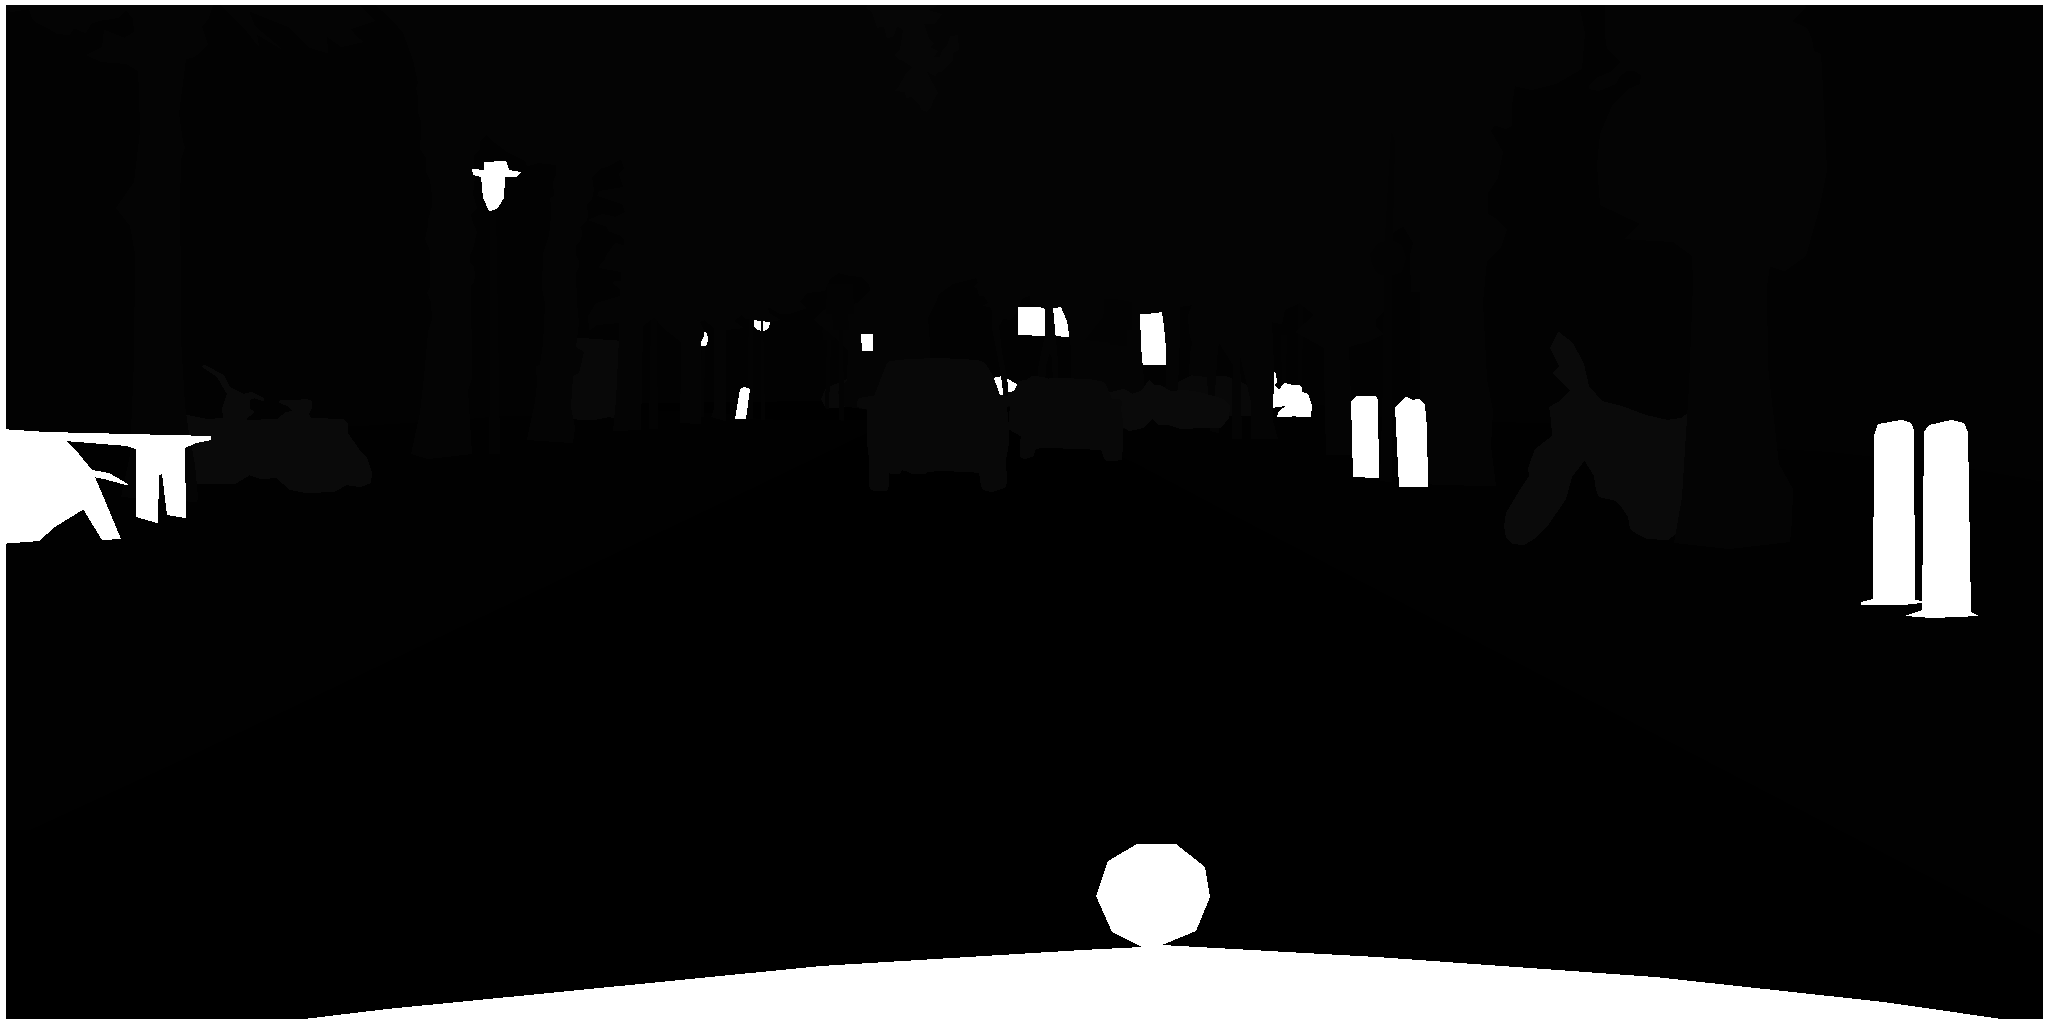

In [ ]:
imf = train_ds["label"][10]
def Convert(x):
  x = numpy.asarray(x)
  x = x - 1
  x = Image.fromarray(x, 'L')
  return x

data = Convert(imf)
data

#data = asarray(img)
#print(numpy.max(data))

In [ ]:
class Dataset(BaseDataset):
    """Cityscape Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['road','sidewalk','building','signboard','vegetation','terrain','sky','person','car','htv','cycle']

    def __init__(
            self,
            example_batch,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        #self.ids = os.listdir(images_dir)
        self.images_fps = [x for x in example_batch["image"]]
        self.masks_fps = [x for x in example_batch["label"]]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = self.images_fps[i]
        mask = Convert(self.masks_fps[i])
        image = np.asarray(image)
        mask = np.asarray(mask)

        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

         # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask

    def __len__(self):
        return len(self.images_fps)


In [ ]:
dataset = Dataset(train_ds, classes= ['road','sidewalk','building','signboard','vegetation','terrain','sky','person','car','htv','cycle'])
len(dataset.CLASSES)
print(dataset.class_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
images,mask = dataset[4]
mask.shape


(1024, 2048, 11)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation(resi = (512,512)):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(*resi)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
augmented_dataset = Dataset(
    train_ds,
    augmentation=get_training_augmentation(),
    classes=['road','sidewalk','building','signboard','vegetation','terrain','sky','person','car','htv','cycle'],
)
test_aug = Dataset(
    test_ds,
    augmentation= get_validation_augmentation(),
    classes= ['road','sidewalk','building','signboard','vegetation','terrain','sky','person','car','htv','cycle'],
)
print(augmented_dataset)
for i in range(3):
    #image, mask = augmented_dataset[1]
    pass


/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

(512, 512, 3)
(512, 512, 11)


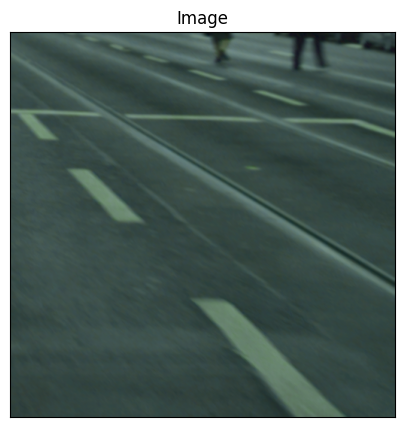

(512, 512, 3)
(512, 512, 11)


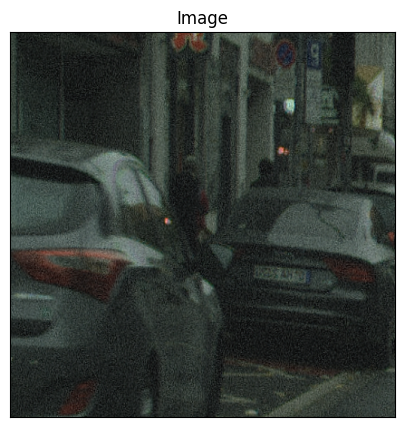

(512, 512, 3)
(512, 512, 11)


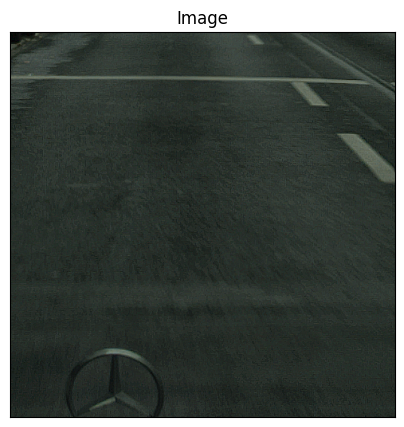

In [ ]:
for i in range(3):
    image, mask = augmented_dataset[2]
    print(image.shape)
    print(mask.shape)
    visualize(image=image)

In [ ]:
import torch
import numpy as np
#!pip install segmentation_models_pytorch

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
len(Cat)

11

In [ ]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = Cat
ACTIVATION = 'softmax2d'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE
CLASSES

['road',
 'sidewalk',
 'building',
 'signboard',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'car',
 'htv',
 'cycle']

In [ ]:
model = smp.DeepLabV3(encoder_name= ENCODER,
                      encoder_weights=ENCODER_WEIGHTS,
                      classes=11,
                      activation=ACTIVATION)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Dataset(train_ds,
                        classes=Cat,
                        augmentation= get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = Dataset(
    test_ds,
    augmentation= get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=Cat,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

In [ ]:
#image, mask = valid_dataset[1]
#mask.shape
test_ds

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB siz

In [ ]:
from segmentation_models_pytorch import utils
loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])
model = torch.load('/content/drive/MyDrive/Classroom/best_model_12.pth')

In [ ]:
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 10):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, dice_loss - 0.2306, iou_score - 0.659]
Model saved!

Epoch: 1
valid: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it, dice_loss - 0.2328, iou_score - 0.6562]

Epoch: 2
valid: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it, dice_loss - 0.2323, iou_score - 0.6566]

Epoch: 3
valid: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it, dice_loss - 0.2305, iou_score - 0.6599]
Model saved!

Epoch: 4
valid: 100%|██████████| 7/7 [00:13<00:00,  1.93s/it, dice_loss - 0.2334, iou_score - 0.6557]

Epoch: 5
valid: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it, dice_loss - 0.2337, iou_score - 0.6559]

Epoch: 6
valid: 100%|██████████| 7/7 [00:12<00:00,  1.80s/it, dice_loss - 0.2323, iou_score - 0.6574]

Epoch: 7
valid: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it, dice_loss - 0.2312, iou_score - 0.6583]

Epoch: 8
valid: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, dice_loss - 0.2315, iou_score - 0.6595]

Epoch: 9
valid: 100%|██████████| 7/7 [00:12<00:

In [ ]:
best_model = torch.load('./best_model.pth')

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model= best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose = True,
)

In [ ]:
logs = test_epoch.run(train_loader)

valid: 100%|██████████| 38/38 [03:33<00:00,  5.62s/it, dice_loss - 0.3358, iou_score - 0.5391]


In [ ]:
logs = test_epoch.run(valid_loader)

valid: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it, dice_loss - 0.2305, iou_score - 0.6599]


In [ ]:
torch.save(model, '/content/drive/MyDrive/Classroom/best_model_13.pth')